# Evolutionary computing
## Assignment III

### Table of Contents
* [Statement](##Statement)
    * [Libraries](###Libraries)
    * [3D surface](###3D_surface)
    * [Parameters](###Parameters)
* [Functions](##Functions)
    * [Binary representation](###Binary_representation)
    * [Real representation](###Real_representation)
    * [Common](###Common)
* [Executive](#Executive)
    * [Binary representation](###Binary_executive)
    * [Real representation](###Real_executive)
* [Results](#chapter3)
    * [Problem 1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2)
    * [Problem 2](#section_3_2)
        * [Sub Section 3.2.1](#sub_section_3_2_1)

### Libraries

In [1]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid') 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from numba import jit, cuda 
import numpy as np
import random

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

import logging;
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
logging.disable(logging.WARNING)

### 3D_surface

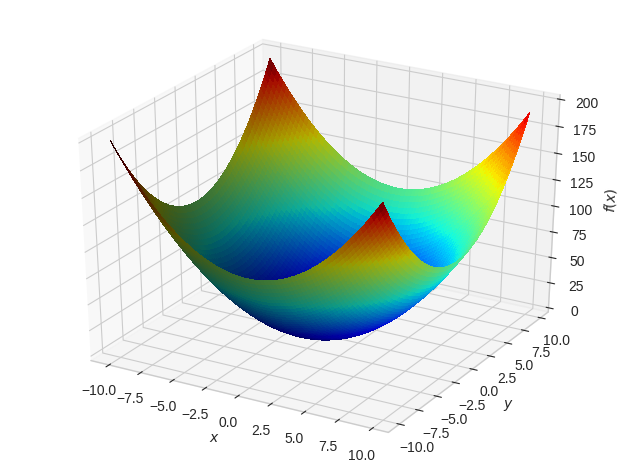

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X=np.arange(-10,10,0.25)
Y=np.arange(-10,10,0.25)
X,Y = np.meshgrid(X,Y)
Z = X**2 + Y**2

my_col = cm.jet(Z/np.amax(Z))

surf = ax.plot_surface(X,Y,Z,linewidth=0,antialiased=False, rstride=1, cstride=1, facecolors = my_col)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$f(x)$')
fig.tight_layout()

plt.show()

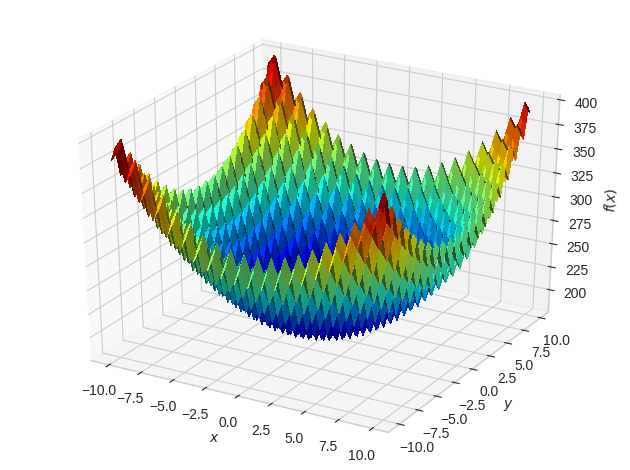

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X=np.arange(-10,10,0.25)
Y=np.arange(-10,10,0.25)
X,Y = np.meshgrid(X,Y)
Z = 10*10 + X**2 - 10*np.cos(2*np.pi*X) + 10*10 + Y**2 - 10*np.cos(2*np.pi*Y)

surf = ax.plot_surface(X,Y,Z,linewidth=0,antialiased=False, rstride=1, cstride=1, facecolors = my_col)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$f(x)$')
fig.tight_layout()
plt.show()

### Parameters

In [4]:
'''Parámetros de entrada
'''
ppl_size = 100 #int(input("Tamaño de la población: "))
generations = 1000 #int(input("Número de generaciones: "))
p_crossover = 1.0 #float(input("Porcentaje de cruza: "))
p_mutation = 0.25 #float(input("Porcentaje de mutación: "))

max_evals = ppl_size*generations
uncertainty = 1.0

## Functions

### Binary_representation

In [5]:
@jit(target_backend='cuda')
def generateBinarySolution(case):
    if (case == 1):
        return np.random.randint(2, size=10*15)
    if (case == 2):
        return np.random.randint(2, size=10*14)

def deterministicSampling(population, apptitudes, no_parents):
    integers = []
    decimals = []
    net_fit = np.array(apptitudes).sum(axis=0)[1]
    for fit_i in apptitudes:
        expected = (fit_i[1]/net_fit)*len(population)
        i, d = divmod(expected, 1)
        decimals.append((fit_i[0],d))
        if (i == 1.0):
            integers.append(fit_i[0])
    decimals = sorted(decimals,key=lambda l:l[1], reverse=True)
    parents = []
    # Si hay suficientes 1 usarlos
    if (len(integers) >= no_parents):
        for cc in range(no_parents):
            indx = integers[cc]
            parents.append(population[indx])
    # Si no hay suficientes usar los que existan
    elif (len(integers) > 0 and len(integers) < no_parents):
        for dd in integers:
            parents.append(population[dd])
    kk = 0
    # Si faltan padres tomar de los decimales
    while (len(parents) < no_parents):
        parents.append(population[decimals[kk][0]])
        kk += 1
    return parents

@jit(target_backend='cuda')
def binaryCrossover(solution1, solution2):    
    cross_pt = random.randint(1, solution1.size-1)
    first_half1  = solution1[:cross_pt]
    second_half1 = solution1[cross_pt:]
    first_half2  = solution2[:cross_pt]
    second_half2 = solution2[cross_pt:]
    sol_1 = np.concatenate((first_half1,second_half2))
    sol_2 = np.concatenate((first_half2,second_half1))
    return sol_1, sol_2

@jit(target_backend='cuda')
def binaryMutation(solution):
    index = random.randint(1, solution.size-1)
    if (solution[index] == 0):
        solution[index] = 1
    else:
        solution[index] = 0
    return solution

### Real_representation

In [6]:
def generateRealSolution(case):
    if (case == 1):
        sol_1 = np.random.uniform(-10,10,10)
        return np.round(sol_1, decimals=3)
    if (case == 2):
        sol_2 = np.random.uniform(-5.12,5.12,10)
        return np.round(sol_2, decimals=3)

def deterministicTournament(population, apptitudes):
    indx_lst = random.sample(range(0, ppl_size), 4)
    parents_subset = []
    for indx in indx_lst:
        parents_subset.append(apptitudes[indx])
    parents_subset.sort(key=lambda a: a[1])
    index_1 = parents_subset[0][0]
    index_2 = parents_subset[1][0]
    parent_1 = population[index_1]
    parent_2 = population[index_2]
    return parent_1, parent_2

def realCrossover(good_solution,bad_solution,alpha,beta):
    H = []
    k = len(good_solution)
    for i in range(0, k):
        I = abs(good_solution[i] - bad_solution[i])
        if (good_solution[i] < bad_solution[i]):
            Li = good_solution[i] - alpha*I
            Ls = bad_solution[i] + beta*I
        else:
            Li = bad_solution[i] - beta*I
            Ls = good_solution[i] + alpha*I
        h_i = np.random.uniform(Li,Ls)
        H.append(h_i)
    son = np.array(H)
    return np.round(son, decimals=3)

def realMutation(solution, case):
    if (case ==1):
        Linf = -10
        Lsup = 10
    if (case ==2):
        Linf = -5.12
        Lsup = 5.12
    index = random.randint(1, solution.size-1)
    solution[index] = np.random.uniform(Linf,Lsup,1)[0]
    return np.round(solution, decimals=3)

### Common

In [7]:
@jit(target_backend='cuda')
def decodeBin2Real(binSolution, case):
    if (case ==1):
        Linf = -10
        Lsup = 10
        L = 15
    if (case ==2):
        Linf = -5.12
        Lsup = 5.12
        L = 14
    split_indx = 0
    d_splits = np.split(binSolution, 10)
    RealSolution = []
    while (split_indx < 10):
        local_indx = 0
        x_integer = 0
        x = d_splits[split_indx]
        while (local_indx<L):
            if (x[local_indx] ==1):
                x_integer += local_indx**2
            local_indx += 1
        x_real = Linf + (x_integer*(Lsup - Linf))/(2**L - 1)
        RealSolution.append(x_real)
        split_indx += 1
    return np.array(RealSolution)

@jit(target_backend='cuda')
def fitness(x, case, isBin = False):
    if (isBin == True):
        x = decodeBin2Real(x,case)  
    if (case == 1):
        fit = np.sum(x**2)
    if (case == 2):
        fit = 10*10 + np.sum(x**2 - 10*np.cos(2*np.pi*x)) 
    return np.round(fit, decimals=3)

@jit(target_backend='cuda')
def generatePopulation(size, case, isBin):
    population = []
    apptitudes = []
    for index in range (0,size):
        if (isBin == True):
            solution = generateBinarySolution(case)
        else:
            solution = generateRealSolution(case)
            solution = np.round(solution, decimals=3)
        apptitude = fitness(solution,case,isBin)
        apptitudes.append((index,apptitude))
        population.append(solution)
    return population, apptitudes

## Executive

### Binary_executive

In [8]:
def executeBinaryRepresentation(c):
    bestApptitude = []
    averageApptitude = []
    best_solution = 0
    flag = False
    population, apptitudes = generatePopulation(ppl_size,case=c,isBin=False)
    evals = 0
    gens = 0
    while (evals < max_evals):
        no_parents = 10
        midle_indx = int(no_parents/2)
        parents = deterministicSampling(population, apptitudes, no_parents)
        sons_a = []
        sons_b = []
        pc = np.random.uniform(0,1,1)[0]
        if (pc <= p_crossover):
            for i in range(midle_indx):
                son_a, son_b = binaryCrossover(parents[i], parents[midle_indx+i])                
                sons_a.append(son_a)
                sons_b.append(son_b)
        else:
            for i in range(midle_indx):
                sons_a.append(parents[i])
                sons_b.append(parents[midle_indx+i])

        pm = np.random.uniform(0,1,1)[0]
        if (pm <= p_mutation):
            for i in range(midle_indx):
                sons_a[i] = binaryMutation(sons_a[i])
                sons_b[i] = binaryMutation(sons_b[i])

        for i in range(midle_indx):
            population.append(sons_a[i])
            population.append(sons_b[i])

        nuevas_aptitudes = []
        for index in range (0,len(population)):
            apptitude = fitness(population[index],case=c,isBin=False)
            nuevas_aptitudes.append((index,apptitude))

        nuevas_aptitudes.sort(key=lambda a: a[1])

        nueva_poblacion = []
        for i in nuevas_aptitudes:
            nueva_poblacion.append(population[i[0]])

        nuevas_aptitudes.clear()
        nueva_poblacion = nueva_poblacion[:ppl_size]     
        average_fit = 0
        for i in range(0,len(nueva_poblacion)):
            apptitude = fitness(nueva_poblacion[i],case=c,isBin=False)
            average_fit += apptitude
            nuevas_aptitudes.append((i,apptitude))
            evals += 1
        population = nueva_poblacion
        apptitudes = nuevas_aptitudes
        average_fit = average_fit/ppl_size
        bestApptitude.append(apptitudes[0][1])
        averageApptitude.append(average_fit)
        if (evals % ppl_size == 0):
            gens += 1
            print(population[apptitudes[0][0]], "f(x)", apptitudes[0][1], "Gen", gens)
        if (apptitudes[0][1] < uncertainty):
            break
    return bestApptitude, averageApptitude

In [9]:
bbest_appt_1, avg_appt_1 = executeBinaryRepresentation(1)

/tmp/ipykernel_11849/3814991739.py:37: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "generatePopulation" failed type inference due to: Untyped global name 'generateRealSolution': Cannot determine Numba type of <class 'function'>

File "../../../../../../../tmp/ipykernel_11849/3814991739.py", line 45:
<source missing, REPL/exec in use?>

  @jit(target_backend='cuda')
/tmp/ipykernel_11849/3814991739.py:37: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "generatePopulation" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../../../../tmp/ipykernel_11849/3814991739.py", line 41:
<source missing, REPL/exec in use?>

  @jit(target_backend='cuda')
/home/jhermosilla/.local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "generatePopulation" was compiled in object mode withou

[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 1
[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 2
[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 3
[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 4
[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 5
[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 6
[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 7
[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 8
[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 9
[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 10
[-1.195  2.717  3.368  1.716  0.275  1.28   2.223 -6.819 -2.34   2.477] f(x) 87.864 Gen 11
[-1.195 

In [10]:
bbest_appt_2, avg_appt_2 = executeBinaryRepresentation(2)

[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 1
[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 2
[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 3
[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 4
[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 5
[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 6
[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 7
[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 8
[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 9
[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 10
[-0.213 -2.34  -0.681 -2.227  1.156  2.042 -0.049 -1.1    1.12  -1.508] f(x) 96.861 Gen 11
[-0.213 

### Real_executive

In [11]:
def executeRealRepresentation(c):
    bestApptitude = []
    averageApptitude = []
    best_solution = 0
    flag = False
    population, apptitudes = generatePopulation(ppl_size,case=c,isBin=False)
    evals = 0
    gens = 0
    while (evals < max_evals):
        parent_1, parent_2 = deterministicTournament(population, apptitudes)
        fit_1 = fitness(parent_1,case=c,isBin=False)
        fit_2 = fitness(parent_2,case=c,isBin=False)
        if (fit_1 < fit_2):
            son_1 = realCrossover(parent_1, parent_2, 0.5, 0.5)
            son_2 = realCrossover(parent_1, parent_2, 0.5, 0.5)
        else: 
            son_1 = realCrossover(parent_2, parent_1, 0.5, 0.5)
            son_2 = realCrossover(parent_2, parent_1, 0.5, 0.5)

        pm = np.random.uniform(0,1,1)[0]
        if (pm <= p_mutation):
            son_1 = realMutation(son_1,c)
            son_2 = realMutation(son_2,c)
        else:
            son_1, son_2 = parent_1, parent_2

        population.append(son_1)
        population.append(son_2)

        nuevas_aptitudes = []
        for index in range (0,len(population)):
            apptitude = fitness(population[index],case=c,isBin=False)
            nuevas_aptitudes.append((index,apptitude))

        nuevas_aptitudes.sort(key=lambda a: a[1])

        nueva_poblacion = []
        for i in nuevas_aptitudes:
            nueva_poblacion.append(population[i[0]])

        nuevas_aptitudes.clear()
        nueva_poblacion = nueva_poblacion[:ppl_size]     
        average_fit = 0
        for i in range(0,len(nueva_poblacion)):
            apptitude = fitness(nueva_poblacion[i],case=c,isBin=False)
            average_fit += apptitude
            nuevas_aptitudes.append((i,apptitude))
            evals += 1
        population = nueva_poblacion
        apptitudes = nuevas_aptitudes
        average_fit = average_fit/ppl_size
        bestApptitude.append(apptitudes[0][1])
        averageApptitude.append(average_fit)
        if (evals % ppl_size == 0):
            gens += 1
            print(population[apptitudes[0][0]], "f(x)", apptitudes[0][1], "Gen", gens)
        if (apptitudes[0][1] < uncertainty):
            break
    return bestApptitude, averageApptitude

In [12]:
bbest_appt_3, avg_appt_3 = executeRealRepresentation(1)

[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 1
[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 2
[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 3
[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 4
[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 5
[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 6
[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 7
[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 8
[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 9
[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 10
[-0.076 -2.68   2.892 -1.17   3.276  2.658  1.975  0.335  8.887 -3.932] f(x) 133.17 Gen 11
[-0.076 

In [13]:
bbest_appt_4, avg_appt_4 = executeRealRepresentation(2)

[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 1
[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 2
[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 3
[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 4
[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 5
[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 6
[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 7
[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 8
[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 9
[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 10
[ 4.096 -1.171  0.188  0.116 -1.019 -0.775  2.075 -0.196 -0.22  -1.842] f(x) 72.298 Gen 11
[ 4.096 

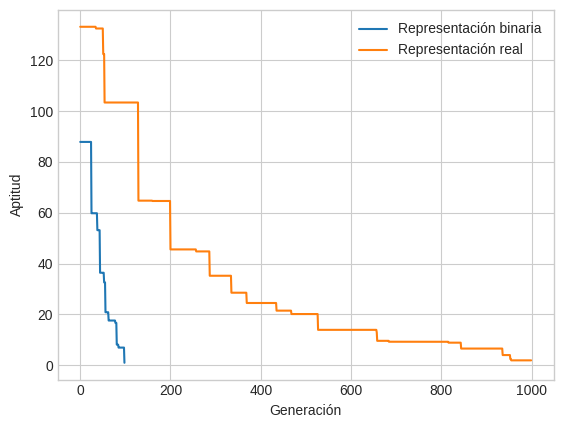

In [14]:
plt.plot(bbest_appt_1, label='Representación binaria')
#plt.plot(avg_appt_1, label='Aptitud promedio')

plt.plot(bbest_appt_3, label='Representación real')
#plt.plot(avg_appt_3, label='Aptitud promedio')

plt.xlabel("Generación")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()

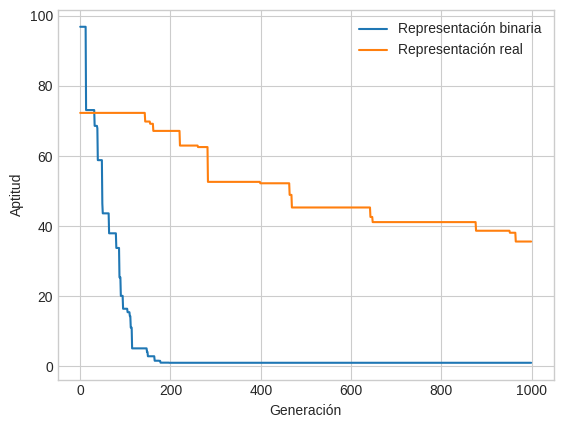

In [15]:
plt.plot(bbest_appt_2, label='Representación binaria')
#plt.plot(avg_appt_2, label='Aptitud promedio')

plt.plot(bbest_appt_4, label='Representación real')
#plt.plot(avg_appt_4, label='Aptitud promedio')

plt.xlabel("Generación")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()